In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from rasterio.plot import show
from rasterstats import zonal_stats

In [2]:
# Load Nepal map shapefile
nepal_map = gpd.read_file('data/Shape_Data/local_unit.shp')

# Convert CRS to EPSG:4326 for consistency
nepal_map = nepal_map.to_crs(epsg=4326)

# Display first few rows
print(nepal_map.head())

# Check available province names
print(nepal_map['Province'].unique())

   STATE_CODE   DISTRICT        GaPa_NaPa     Type_GN Province  \
0           1  TAPLEJUNG  Aathrai Tribeni  Gaunpalika        1   
1           1  TAPLEJUNG       Maiwakhola  Gaunpalika        1   
2           1  TAPLEJUNG        Meringden  Gaunpalika        1   
3           1  TAPLEJUNG       Mikwakhola  Gaunpalika        1   
4           1  TAPLEJUNG     Phaktanglung  Gaunpalika        1   

                                            geometry  
0  POLYGON ((87.60985 27.37043, 87.61107 27.36943...  
1  POLYGON ((87.50402 27.42901, 87.50672 27.42831...  
2  POLYGON ((87.51272 27.56894, 87.51255 27.56859...  
3  POLYGON ((87.6885 27.70975, 87.68891 27.70938,...  
4  POLYGON ((87.83673 27.95137, 87.83735 27.95119...  
['1' '2' 'Bagmati' 'Gandaki' '5' 'Karnali' 'Sudur Pashchim']


In [8]:
# Rename province names for consistency
nepal_map['Province'] = nepal_map['Province'].replace({
    '1': 'Koshi Province',
    '2': 'Madhesh Province',
    'Bagmati': 'Bagmati Province',
    'Gandaki': 'Gandaki Province',
    '5': 'Lumbini Province',
    'Karnali': 'Karnali Province',
    'Sudur Pashchim': 'Sudurpashchim Province'
})

# Verify changes
print(nepal_map['Province'].unique())

['Koshi Province' 'Madhesh Province' 'Bagmati Province' 'Gandaki Province'
 'Lumbini Province' 'Karnali Province' 'Sudurpashchim Province']


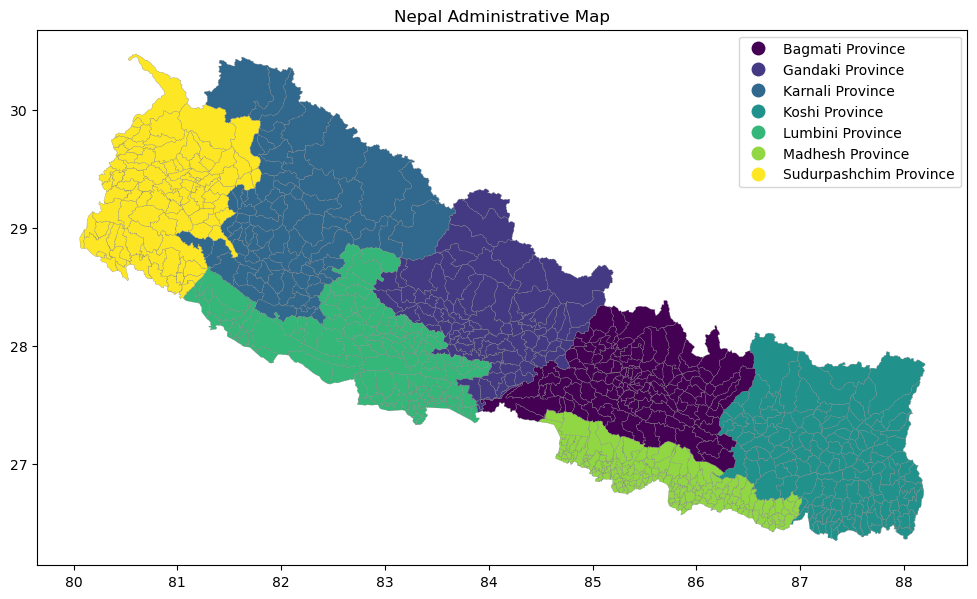

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))
nepal_map.plot(column='Province', cmap='viridis', legend=True, ax=ax, edgecolor='gray', linewidth=0.2)
ax.set_title('Nepal Administrative Map')
plt.show()

In [11]:
# Load climate data (administrative regions)
admin_regions = gpd.read_file('data/nepal_climate_data/nepal_admin_regions.gpkg')

# Display first few rows
print(admin_regions.head())

# Rename provinces for consistency
admin_regions['Province'] = admin_regions['name'].replace({
    'Bagmati': 'Bagmati Province',
    'Province 1': 'Koshi Province',
    'Province 2': 'Madhesh Province',
    'Gandaki': 'Gandaki Province',
    'Lumbini': 'Lumbini Province',
    'Karnali': 'Karnali Province',
    'Sudurpashchim': 'Sudurpashchim Province'
})

# Check available columns
print(admin_regions.columns)

# Verify coordinate reference system
print("admin_regions CRS:", admin_regions.crs)
print("nepal_map CRS:", nepal_map.crs)

         name  climate_vulnerability_2020  climate_vulnerability_2050  \
0  Province 1                    0.449816                    0.656665   
1  Province 2                    0.680286                    0.939022   
2     Bagmati                    0.592798                    0.837280   
3     Gandaki                    0.539463                    0.650687   
4     Lumbini                    0.362407                    0.540340   

                                            geometry  
0  POLYGON ((87 26.5, 88 27, 87.8 28, 87 28.5, 86...  
1  POLYGON ((85 26.5, 87 26.5, 86.5 27.5, 85 27.2...  
2  POLYGON ((85 27.2, 86.5 27.5, 86.2 28.5, 85 28...  
3  POLYGON ((83.5 27.5, 85 27.2, 85 28.2, 84 29, ...  
4  POLYGON ((82 27, 83.5 27.5, 83.5 28, 82.5 28.2...  
Index(['name', 'climate_vulnerability_2020', 'climate_vulnerability_2050',
       'geometry', 'Province'],
      dtype='object')
admin_regions CRS: EPSG:4326
nepal_map CRS: EPSG:4326


In [12]:
# Merge climate vulnerability data with Nepal map
temp = admin_regions.copy()
temp.drop(columns=['geometry'], inplace=True)

nepal_map = nepal_map.merge(temp, on='Province', how='left')

# Drop redundant column
nepal_map.drop(columns=['name'], inplace=True)

# Display merged data
print(nepal_map.head())

   STATE_CODE   DISTRICT        GaPa_NaPa     Type_GN        Province  \
0           1  TAPLEJUNG  Aathrai Tribeni  Gaunpalika  Koshi Province   
1           1  TAPLEJUNG       Maiwakhola  Gaunpalika  Koshi Province   
2           1  TAPLEJUNG        Meringden  Gaunpalika  Koshi Province   
3           1  TAPLEJUNG       Mikwakhola  Gaunpalika  Koshi Province   
4           1  TAPLEJUNG     Phaktanglung  Gaunpalika  Koshi Province   

                                            geometry  \
0  POLYGON ((87.60985 27.37043, 87.61107 27.36943...   
1  POLYGON ((87.50402 27.42901, 87.50672 27.42831...   
2  POLYGON ((87.51272 27.56894, 87.51255 27.56859...   
3  POLYGON ((87.6885 27.70975, 87.68891 27.70938,...   
4  POLYGON ((87.83673 27.95137, 87.83735 27.95119...   

   climate_vulnerability_2020  climate_vulnerability_2050  
0                         NaN                         NaN  
1                         NaN                         NaN  
2                         NaN               

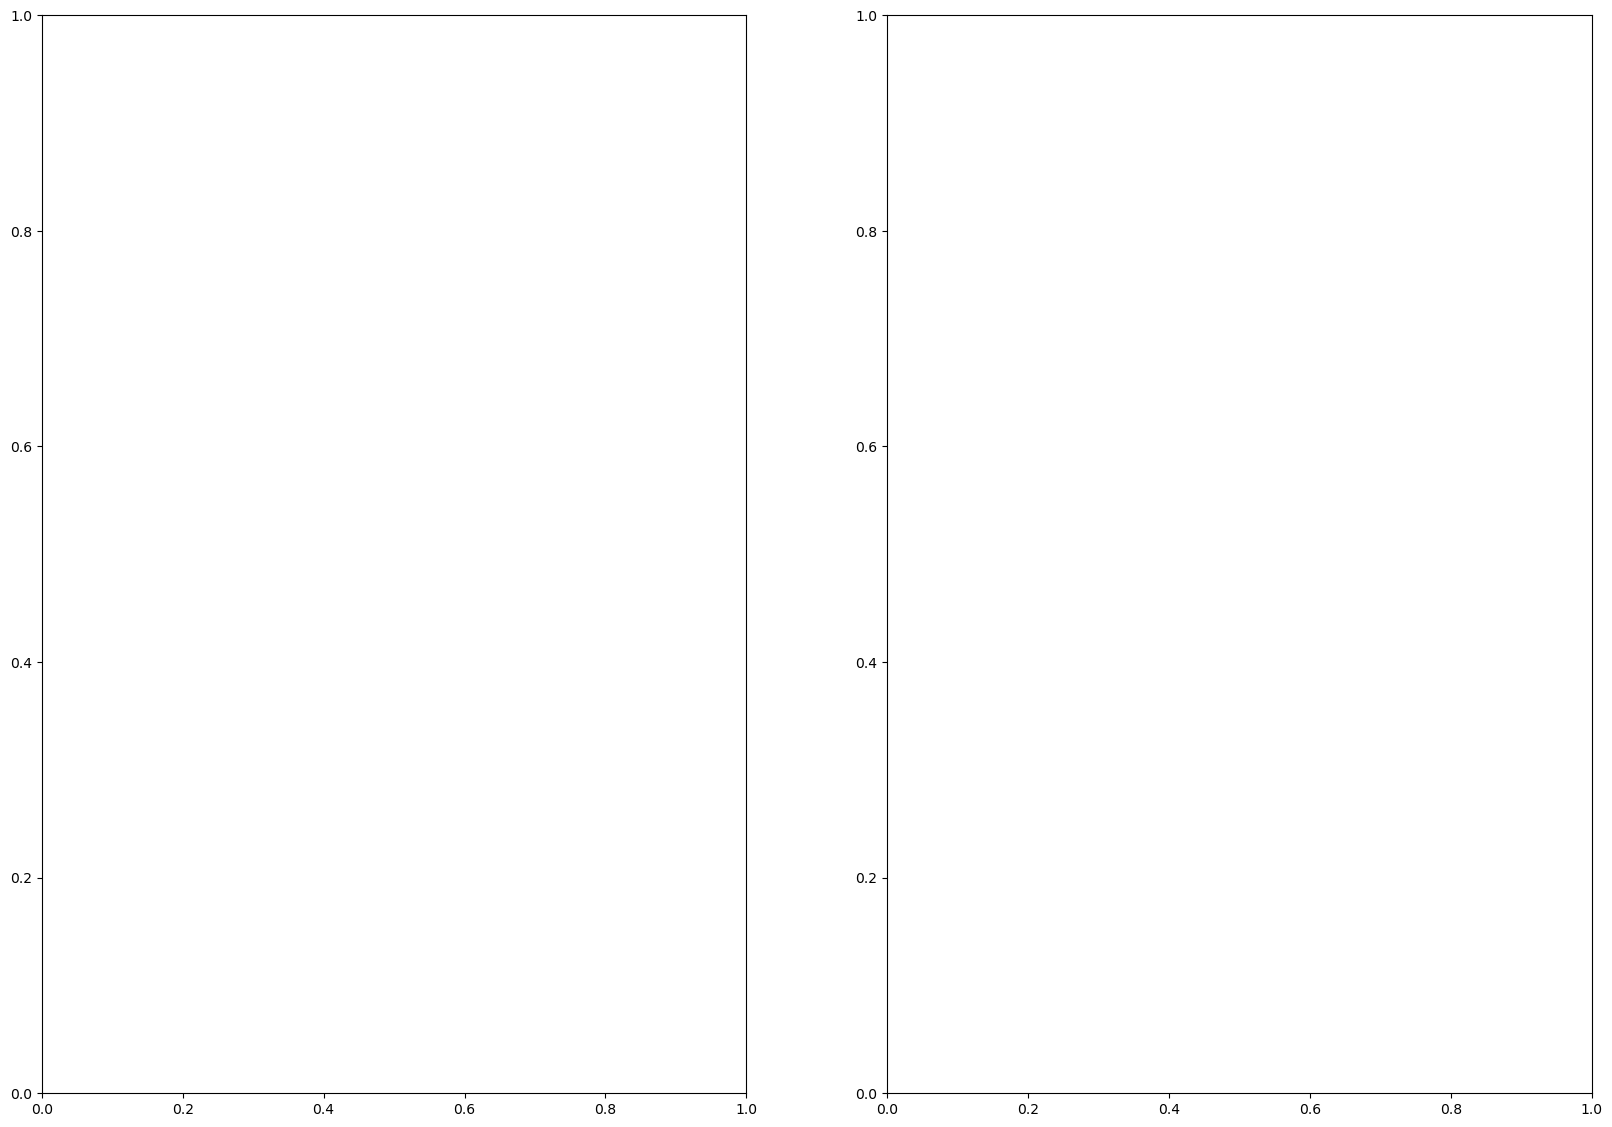

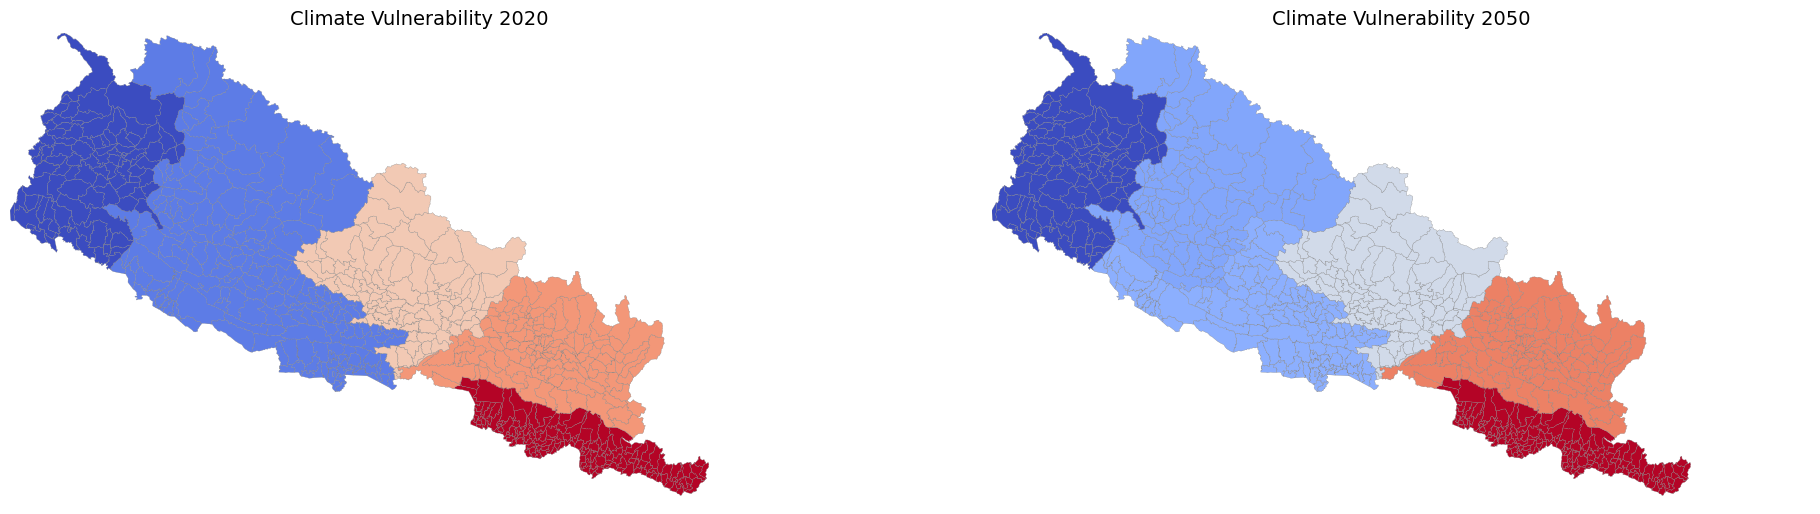

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(20, 14))

nepal_map = nepal_map.to_crs(epsg=4326)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Adjusted aspect ratio

# Get total bounds for consistent axis limits
xlim = (nepal_map.total_bounds[0], nepal_map.total_bounds[2])
ylim = (nepal_map.total_bounds[1], nepal_map.total_bounds[3])

# 2020 Climate Vulnerability
nepal_map.plot(column='climate_vulnerability_2020', ax=axes[0], cmap='coolwarm', edgecolor='grey', linewidth=0.2)
axes[0].set_title('Climate Vulnerability 2020', fontsize=14)
axes[0].set_xlim(xlim)  # Set same x limits for both maps
axes[0].set_ylim(ylim)  # Set same y limits for both maps
axes[0].set_axis_off()

# 2050 Climate Vulnerability
nepal_map.plot(column='climate_vulnerability_2050', ax=axes[1], cmap='coolwarm', edgecolor='grey', linewidth=0.2)
axes[1].set_title('Climate Vulnerability 2050', fontsize=14)
axes[1].set_xlim(xlim)  # Ensure both maps are aligned
axes[1].set_ylim(ylim)
axes[1].set_axis_off()

# Adjust layout to prevent cropping
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

# Show plot
plt.show()

In [15]:
# Load Nepal glaciers data
nepal_glaciers = gpd.read_file('data/nepal_climate_data/nepal_glaciers.gpkg')

# Display first few rows
print(nepal_glaciers.head())

     id  retreat_2020  retreat_2050  increase_pct                   geometry
0  GL01     11.830574     18.308859     54.758846  POINT (83.07123 29.91778)
1  GL02     10.515828     18.451705     75.466020  POINT (87.79586 29.20924)
2  GL03     13.881700     22.644677     63.126114  POINT (86.00235 29.43822)
3  GL04     14.675666     22.894538     56.003401    POINT (84.909 29.54954)
4  GL05     18.200654     25.343086     39.242723   POINT (81.27935 29.6841)


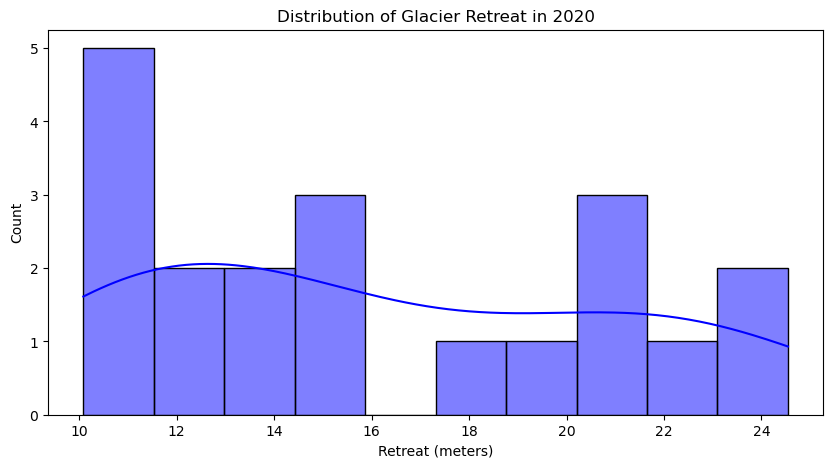

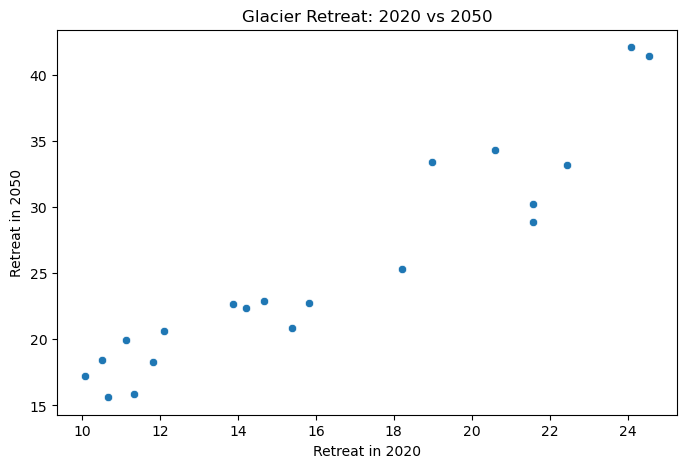

In [17]:
# Histogram for glacier retreat in 2020
plt.figure(figsize=(10, 5))
sns.histplot(nepal_glaciers['retreat_2020'], bins=10, kde=True, color='blue')
plt.title('Distribution of Glacier Retreat in 2020')
plt.xlabel('Retreat (meters)')
plt.ylabel('Count')
plt.show()

# Scatter plot comparing glacier retreat (2020 vs 2050)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=nepal_glaciers['retreat_2020'], y=nepal_glaciers['retreat_2050'])
plt.xlabel('Retreat in 2020')
plt.ylabel('Retreat in 2050')
plt.title('Glacier Retreat: 2020 vs 2050')
plt.show()

       name  flow_2020  flow_2050  flow_reduction_pct  \
0     Koshi       2200       2000            9.090909   
1   Gandaki       1800       1650            8.333333   
2   Karnali       1600       1400           12.500000   
3  Mahakali       1200       1050           12.500000   

                                            geometry  
0  POLYGON ((86 26.5, 86.1 26.5, 87 28, 86.9 28, ...  
1  POLYGON ((84 26.5, 84.1 26.5, 85 28.5, 84.9 28...  
2  POLYGON ((81 26.5, 81.1 26.5, 82 29, 81.9 29, ...  
3  POLYGON ((80 26.5, 80.1 26.5, 80.5 29, 80.4 29...  


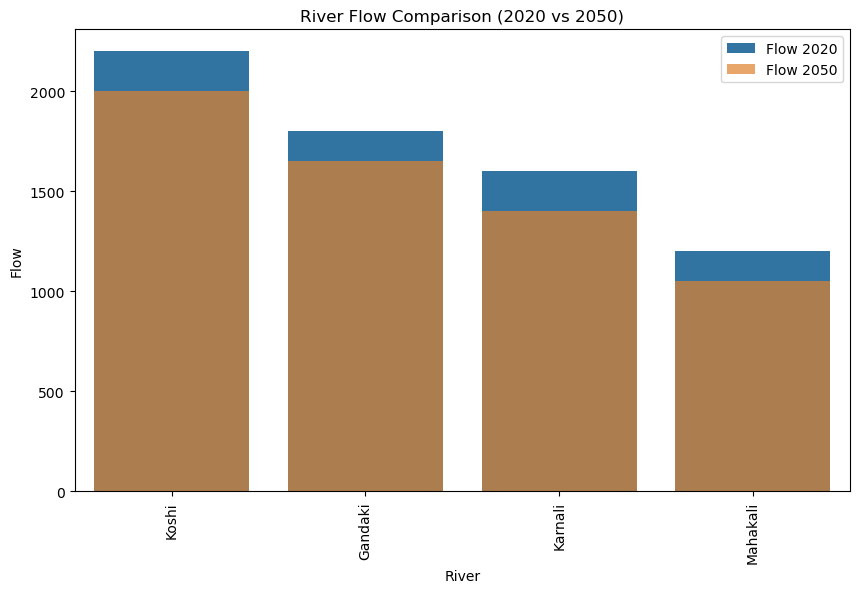

In [20]:
# Load Nepal rivers data
nepal_rivers = gpd.read_file('data/nepal_climate_data/nepal_rivers.gpkg')

# Display first few rows
print(nepal_rivers.head())


plt.figure(figsize=(10, 6))
sns.barplot(x='name', y='flow_2020', data=nepal_rivers, label='Flow 2020')
sns.barplot(x='name', y='flow_2050', data=nepal_rivers, label='Flow 2050', alpha=0.7)
plt.xlabel('River')
plt.ylabel('Flow')
plt.title('River Flow Comparison (2020 vs 2050)')
plt.legend()
plt.xticks(rotation=90)
plt.show()

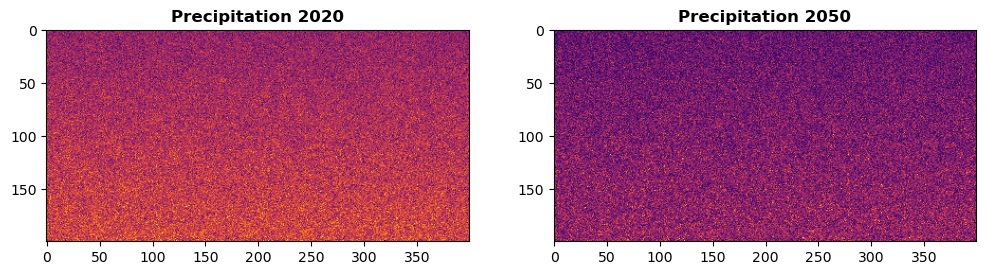

In [21]:
# Load precipitation data (GeoTIFF)
with rasterio.open("data/nepal_climate_data/nepal_precipitation_2020.tif") as src:
    precipitation_2020 = src.read(1)
    
with rasterio.open("data/nepal_climate_data/nepal_precipitation_2050.tif") as src:
    precipitation_2050 = src.read(1)

# Plot Precipitation Data
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
show(precipitation_2020, ax=ax[0], title="Precipitation 2020", cmap="inferno")
show(precipitation_2050, ax=ax[1], title="Precipitation 2050", cmap="inferno")
plt.show()